In [1]:
import numpy as np
import functions as f
from gradient import numerical_gradient
from collections import OrderedDict
from layers import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        #self.layers['Relu1'] = Relu()
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        #self.lastLayer = SoftmaxWithLoss()
        self.lastLayer = IdentityWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

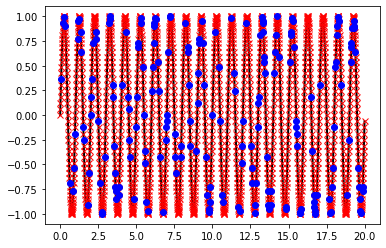

In [10]:
import matplotlib.pyplot as plt

object_fun = lambda x: np.sin(2*np.pi*x)

X_total = np.arange(0, 20, 0.01)
X_total = X_total.reshape(-1,1)
Y_total = object_fun(X_total)
size_x = len(X_total)
plt.plot(X_total, Y_total,color='k',linewidth=2)


# 打乱标签
id = [i for i in range(len(X_total))]
np.random.shuffle(id)
X_total = X_total[id]
Y_total = Y_total[id]

X_train = X_total[0:int(size_x*0.9)]
Y_train = Y_total[0:int(size_x*0.9)]

X_test = X_total[int(size_x*0.9):]
Y_test = Y_total[int(size_x*0.9):]

plt.plot(X_train,Y_train,color='r',marker='x',linewidth=0)
plt.plot(X_test,Y_test,color='b',marker='o',linewidth=0)
plt.show()


In [11]:
## check gradient

network = TwoLayerNet(input_size=1, hidden_size=50, output_size=1)


grad_numerical = network.numerical_gradient(X_train, Y_train)
grad_backprop = network.gradient(X_train, Y_train)


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:1.4786126798380094e-07
b1:1.4603148519576598e-10
W2:1.416120065655946e-10
b2:1.1430856261540612e-10


In [16]:
network = TwoLayerNet(input_size=1, hidden_size=128, output_size=1, weight_init_std = 4*np.sqrt(2.0 / (1+50)))

iters_num = 100000  # 适当设定循环的次数
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 1e-4

train_loss_list = []
test_loss_list = []

iter_per_epoch = max(train_size / batch_size, 1)
iter_num = 1000
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    y_batch = Y_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, y_batch)
    grad = network.gradient(x_batch, y_batch)
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    loss_test = network.loss(X_test, Y_test)
    test_loss_list.append(loss_test)
    
    #if i % iter_per_epoch == 0:
    if i % iter_num == 0:
        print(f"epoch: {i}, train loss, test loss | " + str(loss) + ", " + str(loss_test))

# 绘制图形
x_test =  np.arange(0, 20, 0.005).reshape(-1,1)
y_test = object_fun(x_test)
y_predict = network.predict(x_test)

fig,axs = plt.subplots(1,2)
axs = axs.reshape(-1)

axs[0].plot(x_test,y_test,'b',linewidth=2)
axs[0].plot(x_test,y_predict,':r',linewidth=2)

axs[1].semilogy(train_loss_list,color='k',linewidth=1)
axs[1].semilogy(test_loss_list,color='r',linewidth=1)

plt.show()

epoch: 0, train loss, test loss | 34.50193134575973, 70.8342483393954
epoch: 1000, train loss, test loss | 22.83944582475593, 49.27045465481507
epoch: 2000, train loss, test loss | 22.01824845073412, 49.4445472723411
epoch: 3000, train loss, test loss | 24.222423398258307, 49.870202226718675
epoch: 4000, train loss, test loss | 26.79346636078702, 49.1163744434868
epoch: 5000, train loss, test loss | 26.136597668504923, 49.4211602903852
epoch: 6000, train loss, test loss | 25.66897340482187, 49.16769539534039
epoch: 7000, train loss, test loss | 24.080508351418654, 48.99627865925822
epoch: 8000, train loss, test loss | 25.369936422760095, 49.11278784262561
epoch: 9000, train loss, test loss | 27.02313520224603, 49.11264376311821
epoch: 10000, train loss, test loss | 23.817863463733733, 49.15258670630013
epoch: 11000, train loss, test loss | 23.229297997122675, 49.91286213638502
epoch: 12000, train loss, test loss | 28.555302095119764, 48.96367111247511
epoch: 13000, train loss, test los

KeyboardInterrupt: 

E:\桌面\深度学习数学基础\DeepLearning-Basics\MLP\Solution Given by teacher\functions.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


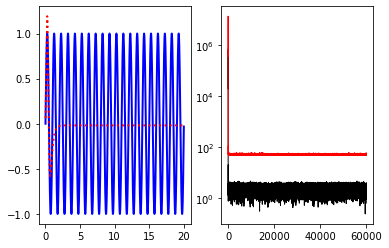

In [15]:
# 绘制图形
x_test =  np.arange(0, 20, 0.005).reshape(-1,1)
y_test = object_fun(x_test)
y_predict = network.predict(x_test)

fig,axs = plt.subplots(1,2)
axs = axs.reshape(-1)

axs[0].plot(x_test,y_test,'b',linewidth=2)
axs[0].plot(x_test,y_predict,':r',linewidth=2)

axs[1].semilogy(train_loss_list,color='k',linewidth=1)
axs[1].semilogy(test_loss_list,color='r',linewidth=1)

plt.show()